In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import qutip as qt 
from ECD_control.ECD_optimization.batch_optimizer import BatchOptimizer
from ECD_control.ECD_optimization.optimization_analysis import OptimizationAnalysis, OptimizationSweepsAnalysis
from ECD_control.ECD_pulse_construction.ECD_pulse_construction import *
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3683900666326055105]

In [4]:
#The target oscillator state.
N =40
alpha = 2.0
psi_t = (qt.coherent(N,alpha) + qt.coherent(N,-1*alpha)).unit()

In [5]:
#Optimization of ECD Circuit parameters (betas, phis, and thetas)
#the optimization options
opt_params = {
'N_blocks' : 4, #circuit depth
'N_multistart' : 200, #Batch size (number of circuit optimizations to run in parallel)
'epochs' : 200, #number of epochs before termination
'epoch_size' : 10, #number of adam steps per epoch
'learning_rate' : 0.01, #adam learning rate
'term_fid' : 0.999, #terminal fidelitiy
'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
'beta_scale' : 4.0, #maximum |beta| for random initialization
'initial_states' : [qt.tensor(qt.basis(2,0),qt.basis(N,0))], #qubit tensor oscillator, start in |g> |0>
'target_states' : [qt.tensor(qt.basis(2,1), psi_t)], #end in |e> |target>.
'name' : 'cat alpha=%.3f' % alpha, #name for printing and saving
'filename' : None, #if no filename specified, results will be saved in this folder under 'name.h5'
}
#note: optimizer includes pi pulse in every ECD step. However, final ECD step is implemented 
#in experiment as a displacement since the qubit and oscillator should be disentangled at this point.
#So, we ask the optimizer to end in |e> |target> instead of |g>|target>.

In [6]:
#create optimization object. 
#initial params will be randomized upon creation
opt = BatchOptimizer(**opt_params)

#print optimization info. 
opt.print_info()

optimization_type: state transfer
N_multistart: 200
N_blocks: 4
term_fid: 0.999
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 4.0
alpha_scale: 1.0
theta_scale: 3.141592653589793
use_displacements: False
use_phase: False
name: cat alpha=2.000
comment: 
N_cav: 40
filename: cat alpha=2.h5

Best circuit parameters found:
betas:         [-3.61893-1.17949j -1.40445-0.95057j -0.61868-0.76805j -1.14503-0.0166j ]
alphas:        [0.+0.j]
phis (deg):    [  0.      176.27429   2.12209 -61.24312]
thetas (deg):  [ 75.8692  -14.51408 -92.51202 116.40619]
Max Fidelity:  0.221136




In [7]:
#run optimizer.
#note the optimizer can be stopped at any time by interrupting the python consle,
#and the optimization results will still be saved and part of the opt object.
#This allows you to stop the optimization whenever you want and still use the result.
opt.optimize()

Start time: 2022-01-14 10:23:04
 Epoch: 19 / 200 Max Fid: 0.997041 Avg Fid: 0.614832 Max dFid: 0.142414 Avg dFid: 0.005682 Elapsed time: 0:02:31.449615 Remaing time: 0:24:02.756859

KeyboardInterrupt: 

In [8]:
#can print info, including the best circuit found.
opt.print_info()

optimization_type: state transfer
N_multistart: 200
N_blocks: 4
term_fid: 0.999
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 4.0
alpha_scale: 1.0
theta_scale: 3.141592653589793
use_displacements: False
use_phase: False
name: cat alpha=2.000
comment: 
N_cav: 40
filename: cat alpha=2.h5

Best circuit parameters found:
betas:         [-3.98977-0.21043j  0.02191-0.43593j  0.31841+0.14485j  0.00245-0.01343j]
alphas:        [0.+0.j]
phis (deg):    [   0.       -87.24234  -93.95329 -175.57237]
thetas (deg):  [ 89.99934 -60.27512 106.79401 -90.86782]
Max Fidelity:  0.997052




In [9]:
#can also get the best circuit parameters directly, could save this to a .npz file.
best_circuit =  opt.best_circuit()
betas = best_circuit['betas']
phis = best_circuit['phis']
thetas = best_circuit['thetas']
print(best_circuit)
np.savez('cat_prep_alpha_%.3f_N_%d.npz' % (alpha, 4))

{'fidelity': 0.99705213, 'betas': array([-3.9897673e+00-0.21043348j,  2.1910433e-02-0.4359328j ,
        3.1840619e-01+0.1448528j ,  2.4521374e-03-0.01342809j],
      dtype=complex64), 'alphas': array([0.+0.j], dtype=complex64), 'phis': array([ 0.       , -1.5226661, -1.6397945, -3.064316 ], dtype=float32), 'thetas': array([ 1.5707848, -1.0519993,  1.8639071, -1.5859427], dtype=float32)}


In [14]:
#Analysis of the results. Can load the .h5 file.
#all data is stored as a timestamp in a .h5 file
#You can also specify which timestamp you are analyzing. Be defult, it will use the most recent optimization in the file.
#I  recommend using "HDFview" software to understand data structure
#filename = opt.filename #could use this to get filename
filename = 'cat alpha=2.h5'
print(filename)
analysis = OptimizationAnalysis(filename)
analysis.print_info() #we can print info of best circuit

cat alpha=2.h5
N_blocks: 4
N_cav: 40
N_multistart: 200
alpha_scale: 1.0
beta_scale: 4.0
comment: 
dfid_stop: 1e-06
elapsed_time_s: 151.44961500167847
epoch_size: 10
epochs: 200
learning_rate: 0.01
name: cat alpha=2.000
no_CD_end: False
optimization_type: state transfer
term_fid: 0.999
termination_reason: outside termination
theta_scale: 3.141592653589793
use_displacements: False
use_phase: False
filename: cat alpha=2.h5

Best circuit parameters found:
betas:         [-3.98907-0.21357j  0.02248-0.43721j  0.31696+0.14669j  0.00264-0.014j  ]
alphas:        [0.+0.j]
phis (deg):    [   0.       -87.10491  -93.95815 -175.61952]
thetas (deg):  [ 89.99384 -59.884   106.98815 -90.76376]
Max Fidelity:  0.997041




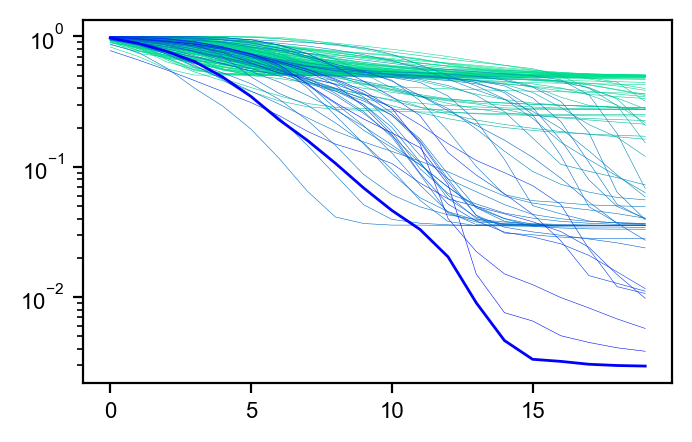

In [15]:
#We can plot the fidelities of the different parallel optimizations. 
# x axis is epoch
analysis.plot_fidelities()

In [16]:
#Now, we can take the parameters found (betas, phis, and thetas)
#and use them to produce a ECD oscillator and qubit pulse.
#This requies us to specify the calibrated experimental parameters.

#The following parameters for the oscillator will be used to build the oscillator pulse.
#Here, assume that a gaussian displacement pulse to alpha=1.0 has been calibrated.
storage_params = {
        "chi_kHz": 33, #dispersive shift in kHz
        "chi_prime_Hz": 1, #second order dispersive shift in Hz
        "Ks_Hz": 0, #Kerr correction not implemented here.
        "unit_amp": 0.01, #DAC amplitude (at maximum of pulse) for gaussian displacement to alpha=1.
        "sigma": 11, #oscillator displacement pulse sigma
        "chop": 4, #oscillator displacement pulse chop (number of sigmas to include in gaussian pulse)
    }

#In a similar way, the qubit pulse parameters will be specified by a calibrated pi pulse.
#unit_amp is the DAC amplitude (at maximum of pulse) for a calibrated gaussian pi pulse, with sigma and chop specified
qubit_params = {'unit_amp': 0.5, 'sigma': 6, 'chop': 4} #parameters for qubit pi pulse.


#creating the "Fake storage" and "Fake qubit" objects which are used
#for pulse cration
storage = FakeStorage(**storage_params)
qubit = FakeQubit(**qubit_params)

#The maximum displacement used during the ECD gates.
alpha_CD = 30
#Small delay to insert between oscillator and qubit pulses to ensure timing is okay.
buffer_time = 4

In [17]:
#From these calibrations, the storage and qubit objects calculate the
#conversion between DAC amplitude, and drive amplitude in MHz.
#so, [Omega(t) in MHz] = [Omega(t) in DAC units]*Omega_m_MHz 
#and [Omega(t) in MHz] = [Omega(t) in DAC units]*Omega_m_MHz.
#These parameters also represent the maximum drive amplitude,
#since the DAC max amplitude is 1 (assuming amplifiers don't saturate.)
print('Maximum oscillator drive amplitude: |epsilon|/2*pi < %.3f MHz' % storage.epsilon_m_MHz)
print('Maximum qubit drive amplitude: |Omega|/2*pi < %.3f MHz' % qubit.Omega_m_MHz)

Maximum oscillator drive amplitude: |epsilon|/2*pi < 690.790 MHz
Maximum qubit drive amplitude: |Omega|/2*pi < 40.468 MHz


In [18]:
#generating the oscillator and qubit pulses (epsilon and Omega)
#set 'chi_prime_correction = True' to correct for linear part of chi'
#final_disp = True will implement final ECD gate as a gaussian displacement instead of full ECD gate.
#This option is useful if the qubit and oscillator are disentangled after the gate.
pulse_dict = conditional_displacement_circuit(betas, phis, thetas, storage, qubit,
                     alpha_CD,buffer_time=buffer_time, kerr_correction = False, chi_prime_correction=True, final_disp=True, pad=True)

#The dictionary will contain the pulses, in DAC units.
#Also, the displacements used for each ECD gate (the "alphas")
cavity_dac_pulse, qubit_dac_pulse,alphas = pulse_dict['cavity_dac_pulse'], pulse_dict['qubit_dac_pulse'], pulse_dict['alphas']
print('alphas:')
print(alphas)

C:\ProgramData\Miniconda3\envs\opt3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


alphas:
[30.0, 22.848974064236515, 18.45159451156261]


Text(0.5, 0, 'ns')

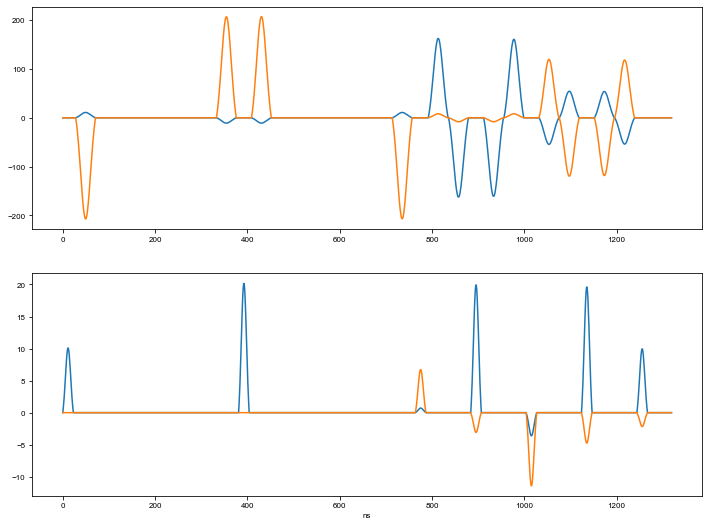

In [19]:
#plotting the pulse, in units of MHz. It could also be fed into a time-domain simulation.
fig, axs = plt.subplots(2,1)
axs[0].plot(np.real(storage.epsilon_m_MHz*cavity_dac_pulse))
axs[0].plot(np.imag(storage.epsilon_m_MHz*cavity_dac_pulse))
axs[1].plot(np.real(qubit.Omega_m_MHz*qubit_dac_pulse))
axs[1].plot(np.imag(qubit.Omega_m_MHz*qubit_dac_pulse))
plt.xlabel('ns')